Analysis on Munich Airbnb Data
==========================

This notebook conatins an analysis of AirBnB data for the city of Munich, Germany. The data has been retrived from the site http://insideairbnb.com/get-the-data.html dated March 19, 2020.
The structure of the notebook follows the CRISP-DM process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from PIL import Image
import requests

import seaborn as sns
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

# plots to be rendered directly in the notebook
%matplotlib inline 

## Business Understanding

Beside basic statics (how many accomodations arre listed, which is the most prominent room type ...), this analysis will answer 
the following questions:

- Which room types are the most prominent ones ?
- Do different city districts favor different room types ? 
- How do the number of listed locations and the and rooms / appartment prices vary by city district ?
- How did demand for Airbnb rentals develop historically and how does it fluctuate seasonally ? Can we already see an impact of the COVID-19 situation  on the demand ?
-  What about seasonility ? How do the rental prices fluctuate over the year / within a week ?¶

In [2]:
# read in data
df_calendar = pd.read_csv('./data/calendar.csv')
df_listings = pd.read_csv('./data/listings.csv', low_memory = False)  # to ensure no mixed types 
df_reviews = pd.read_csv('./data/reviews.csv')

## Data Understanding

We first define some helper function to simplify modularization within a production system

In [3]:
def df_nan_analysis(df):
    """
        This function analyses both the absolute and relative number of nan elements in the different columns of a dataset
        It generates an overview table by attribute
        Args:
            df: Dataframe to be analysed
            
        Returns:
            df_report: Dataframe containing analysis results:
                - attribute: Attribute name
                - nan_abs: Absolute count of nan-values for this attribute
                - nan_rel: Relative frequency of nan-values for this attribute
      
    """
    df_analysis = df.isnull().sum()
    df_report = pd.DataFrame([])
    for key, value in df_analysis.iteritems():
        df_report = df_report.append({'attribute':key, 'nan_abs':value, 'nan_rel': str(round(100*value/df.shape[0],6))+'%'}, ignore_index=True)
    
    df_report['nan_abs'] = df_report['nan_abs'].astype(int)
    
    return df_report

def upper_whisker(s):
    """
        This function calculates the upper whisker of a pandas series defined as 
        Third quartile (Q3 / 75th Percentile) + 1.5 IQR (Interquartile Range)
        IQR = Third quartile (Q3 / 75th Percentile) - First quartile (Q1 / 25th Percentile)
        
        Args:
            pandas series
        Returns:
            upper whisker value as float
            quantile q as float
    """
    Q1 = s.quantile(q=.25)
    Q3 = s.quantile(q=.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + 1.5 * IQR
    q = s[s <= upper_whisker].size / s.size
    return upper_whisker, q

def transform_price(s_price):
    """
        Transform the price data (contained in several columns both in listings and date) to float
        Function can handle nan values (returns nan in this case)
        Args:
            pandas series with price data in format $x,xxx.xx
        Returns:
            pandas series with price data transformed to float - returns nan for rows that contained originally nan
    """
    return s_price.str.replace('$', '').str.replace(',', '').astype(float)

def transform_percentage(s_percentage):
    """
        Transform percentage data (contained e.g. in columns host_response_rate, host_acceptance_rate 9 in listings) to float
        Function can handle nan values (returns nan in this case)
        Args:
            pandas series with price data in format xxx%
        Returns:
            pandas series with percentage data transformed to float - returns nan for rows that contained originally nan
    """
    return s_percentage.str.replace('%', '').astype(float)/100


# lambda function to transform 't', 'f' into boolean
transform_boolean = lambda x: (True if x == "t" else False)

# set global constant for chart coloring
base_color = sns.color_palette()[0]

### Listings data
First we generate some high-level overviews of the listings data

In [4]:
# high-level overview of data shape and composition
print('Shape of listing-Dataframe: ', df_listings.shape)
df_listings.head()

Shape of listing-Dataframe:  (11199, 106)


id                          listing_url       scrape_id last_scraped  \
0   36720   https://www.airbnb.com/rooms/36720  20200319220654   2020-03-20   
1   49309   https://www.airbnb.com/rooms/49309  20200319220654   2020-03-20   
2   97945   https://www.airbnb.com/rooms/97945  20200319220654   2020-03-20   
3  114695  https://www.airbnb.com/rooms/114695  20200319220654   2020-03-20   
4  127383  https://www.airbnb.com/rooms/127383  20200319220654   2020-03-20   

                                              name  \
0              Beautiful 2 rooms flat, Glockenbach   
1  Sublet - Apartment with Balcony in Downtown (1)   
2                 Deluxw-Apartm. with roof terrace   
3               Apartment Munich/East with sundeck   
4                City apartment next to Pinakothek   

                                             summary  \
0  Very quiet, yet centrally located 2 rooms apt....   
1  we are a young family of 4 and will be travell...   
2                                                NaN   
3                                                NaN   
4  Die Wohnung hat 55 qm und ist voll ausgestatte...   

                                               space  \
0  2-Zimmer Altbauwohung Beste Lage, zentral, im ...   
1  we offer one very bright room with balcony, a ...   
2  We offer a modern, quiet apartment with a sunn...   
3  It´s a quiet and sunny apartment close to the ...   
4  My cosy apartment is located in the heart of M...   

                                         description experiences_offered  \
0  Very quiet, yet centrally located 2 rooms apt....                none   
1  we are a young family of 4 and will be travell...                none   
2  We offer a modern, quiet apartment with a sunn...                none   
3  It´s a quiet and sunny apartment close to the ...                none   
4  My cosy apartment is located in the heart of M...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Glockenbachviertel area has the hippest restau...  ...                f   
1  the neighborhood "schlachthofviertel" is one o...  ...                f   
2  We are living in a outskirt of Munich its call...  ...                f   
3                                                NaN  ...                f   
4                                                NaN  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f                     moderate   
2                        f                     flexible   
3                        f  strict_14_with_grace_period   
4                        f                     flexible   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             t                                f   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                               2   
3                               2   
4                               2   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            0   
2                                            2   
3                                            2   
4                                            1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            1   
2                                            0   
3                                            0   
4                                            1   

   calculated_host

[Discussions found in the web](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/discussion/111835) state that the *availability_365* - field gives an indication if this is still an active listing. A value of zero would indiacte that this listing is no longer active. So we drop all listings that are non-active by this defintion.

In [5]:
count_dropout = df_listings[df_listings['availability_365'] == 0].shape[0]
print("We drop %d listings that are apparently no longer active" %(count_dropout))
df_listings_cleansed = df_listings.drop(df_listings[df_listings.availability_365 == 0].index)
df_listings_cleansed.reset_index(inplace = True)
ratio = round(100*count_dropout/df_listings.shape[0],1)
print(f"This is {ratio} % of the listings contained in the original list and leaves us with {df_listings_cleansed.shape[0]} listings")

We drop 5999 listings that are apparently no longer active
This is 53.6 % of the listings contained in the original list and leaves us with 5200 listings


Furthermore we drop all columns that contai only one unique value and thus not contain additional inofrmation for the different datasets

In [6]:
# drop any column that contain one constant value only
print('Drop following colums as they contain one constant value only: \n' + str(df_listings_cleansed.columns[df_listings_cleansed.nunique()==1].to_list()))
df_listings_cleansed.drop(columns= df_listings_cleansed.columns[df_listings_cleansed.nunique()==1].to_list(), inplace = True)

Drop following colums as they contain one constant value only: 
['scrape_id', 'experiences_offered', 'country_code', 'country', 'has_availability', 'requires_license', 'is_business_travel_ready']


Let's have a look at the nan-data in the different columns of the remaining rows. Light color indicates nan-values.

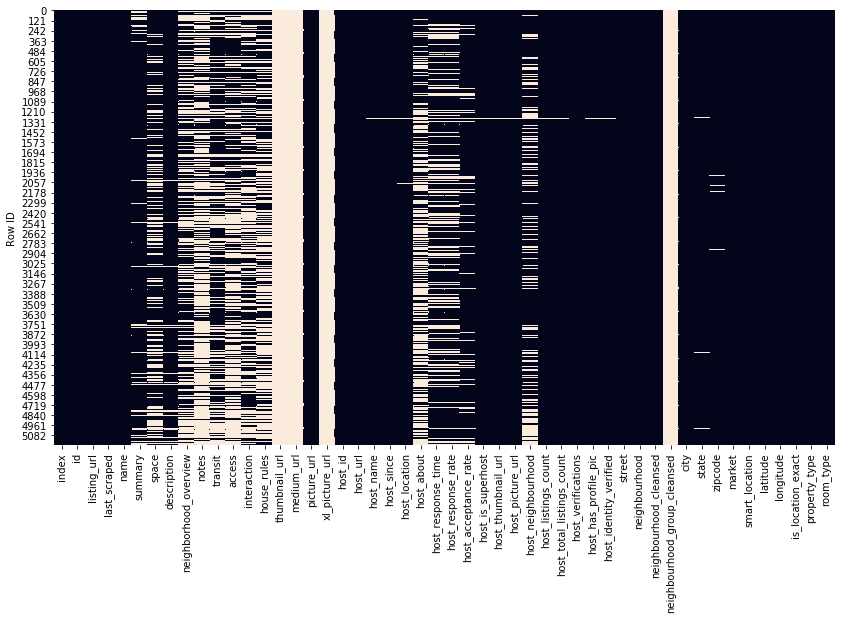

In [7]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df_listings_cleansed.iloc[:,0:50].isnull(), cbar=False);
plt.ylabel('Row ID', fontsize = 10);
ax.tick_params(axis='both', labelsize=10)

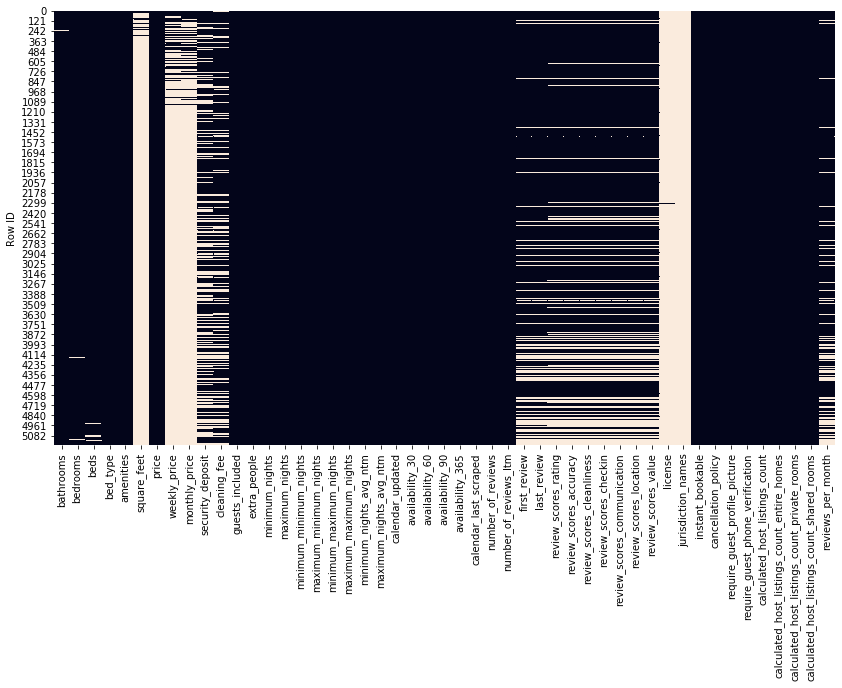

In [8]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df_listings_cleansed.iloc[:,51:].isnull(), cbar=False);
plt.ylabel('Row ID', fontsize = 10);
ax.tick_params(axis='both', labelsize=10)

The plot gives the impression that several columns contain nan-values only. We double-check this by clculating the exact figures

In [9]:
df = df_nan_analysis(df_listings_cleansed).sort_values(by='nan_abs', ascending = False)
df.head(15)

attribute  nan_abs     nan_rel
90            jurisdiction_names     5200      100.0%
39  neighbourhood_group_cleansed     5200      100.0%
17                xl_picture_url     5200      100.0%
15                    medium_url     5200      100.0%
14                 thumbnail_url     5200      100.0%
89                       license     5187      99.75%
56                   square_feet     5096       98.0%
59                 monthly_price     4798  92.269231%
58                  weekly_price     4746  91.269231%
9                          notes     3441  66.173077%
11                        access     2781  53.480769%
23                    host_about     2562  49.269231%
13                   house_rules     2533  48.711538%
12                   interaction     2301      44.25%
8          neighborhood_overview     2098  40.346154%

In a first step we drop all the columns with more than 95% nan-values. The only reason we keep the other columns is that we want to use the *weekly_price* / *monthly_price* for an analysis regarding the discount policy of the renter

In [10]:
# drop all columns in listings that have more than 95% nan-values. 

print('We drop the columns with more than 95% nan-values. This refers to the following columns:')

nan_s = df_listings_cleansed.columns[df_listings_cleansed.isnull().mean()>.95]
for s in range(len(nan_s)):
    print('- ', nan_s[s])

df_listings_cleansed = df_listings_cleansed.dropna(thresh = len(df_listings_cleansed)*.05, axis=1)

print(len(nan_s), ' columns dropped')   

We drop the columns with more than 95% nan-values. This refers to the following columns:
-  thumbnail_url
-  medium_url
-  xl_picture_url
-  neighbourhood_group_cleansed
-  square_feet
-  license
-  jurisdiction_names
7  columns dropped


#### Data transformations in listings table
We first check the datatypes to identfy variables that require a datatype transformation

In [11]:
df_listings_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 93 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         5200 non-null   int64  
 1   id                                            5200 non-null   int64  
 2   listing_url                                   5200 non-null   object 
 3   last_scraped                                  5200 non-null   object 
 4   name                                          5199 non-null   object 
 5   summary                                       4831 non-null   object 
 6   space                                         3634 non-null   object 
 7   description                                   5045 non-null   object 
 8   neighborhood_overview                         3102 non-null   object 
 9   notes                                         1759 non-null   o

Following transformations appear necessary:
- transform pricing data to float (note: even as these prices are labeled with **'$'**, a comparison with the AirBnB website reveals that the prices are in EUR.
- transform columns that contain boolean information but are currently labelled with 't' / 'f' to true boolean
- transform dates to datetime
- transform percentages to float

In [12]:
# transform price columns to float
# price columns are manually selected
price_cols = ['price', 'weekly_price', 'monthly_price', 'extra_people', 'security_deposit', 'cleaning_fee']

for col in price_cols:
    df_listings_cleansed[col] = transform_price(df_listings_cleansed[col])

print('Transformed price columns to float: \n', price_cols)
    
# transform boolean columns   
# boolean columns contain 't' or 'f' entries only and can be selected automatically
df = pd.DataFrame(df_listings_cleansed.iloc[0, 0:df_listings_cleansed.shape[1]].reset_index())
boolean_cols  = list(df[(df[0] == 'f') | (df[0] == 't')]['index'])

for col in boolean_cols:
    df_listings_cleansed[col] = df_listings_cleansed[col].apply(transform_boolean)
    
print('\n Transformed following columns to booelan: \n', boolean_cols)
    
# transform date columns 
date_cols =  ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

for col in date_cols:
    df_listings_cleansed[col] = pd.to_datetime(df_listings_cleansed[col], format="%Y-%m-%d")
    
print('\n Transformed following columns to datetime: \n', date_cols)
    
# transform percentage columns
percentage_cols = ['host_response_rate', 'host_acceptance_rate']

for col in percentage_cols:
    df_listings_cleansed[col] = transform_percentage(df_listings_cleansed[col])
    
print('\n Transformed percentage columns to float: \n', percentage_cols)

Transformed price columns to float: 
 ['price', 'weekly_price', 'monthly_price', 'extra_people', 'security_deposit', 'cleaning_fee']

 Transformed following columns to booelan: 
 ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']

 Transformed following columns to datetime: 
 ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']

 Transformed percentage columns to float: 
 ['host_response_rate', 'host_acceptance_rate']


#### Impute missing values in listings table
Based on the nan-analysis done earlier missing values in following columns are imputed
- weekly / monthly prices based on daily prices
- beds, bedrooms, bothrooms based on mode
- security_deposit, cleaning_fee with  zeros

In [13]:
# weekly_price
def week_price(d_price, w_price):
    if np.isnan(w_price):
        return 7*d_price
    else:
        return w_price

df_listings_cleansed['weekly_price'] = [week_price(df_listings_cleansed.loc[i,'price'] , 
                                                   df_listings_cleansed.loc[i, 'weekly_price']) 
                                        for i in range(len(df_listings_cleansed))]

# monthly_price
def month_price(d_price, m_price):
    if np.isnan(m_price):
        return 30*d_price
    else:
        return m_price

df_listings_cleansed['monthly_price'] = [month_price(df_listings_cleansed.loc[i,'price'] , 
                                                     df_listings_cleansed.loc[i, 'monthly_price']) 
                                         for i in range(len(df_listings_cleansed))]


# Fill mode to beds, bedrooms, bathrooms
# as mode-function returns an ordered list we need to select the first element 
for col in ['beds', 'bedrooms', 'bathrooms']:
    df_listings_cleansed[col].fillna(df_listings_cleansed[col].mode()[0], inplace = True)

# Fill 'security_deposit', 'cleaning_fee' with zeros
for col in ['security_deposit', 'cleaning_fee']:
    df_listings_cleansed[col].fillna(0, inplace = True)

In [14]:
df_listings_cleansed.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   listing_url             5200 non-null   object
 1   name                    5199 non-null   object
 2   summary                 4831 non-null   object
 3   space                   3634 non-null   object
 4   description             5045 non-null   object
 5   neighborhood_overview   3102 non-null   object
 6   notes                   1759 non-null   object
 7   transit                 3512 non-null   object
 8   access                  2419 non-null   object
 9   interaction             2899 non-null   object
 10  house_rules             2667 non-null   object
 11  picture_url             5200 non-null   object
 12  host_url                5200 non-null   object
 13  host_name               5199 non-null   object
 14  host_location           5179 non-null   object
 15  host

To get a better understanding we create pairplots for some selected variables.

<Figure size 2160x2160 with 0 Axes>

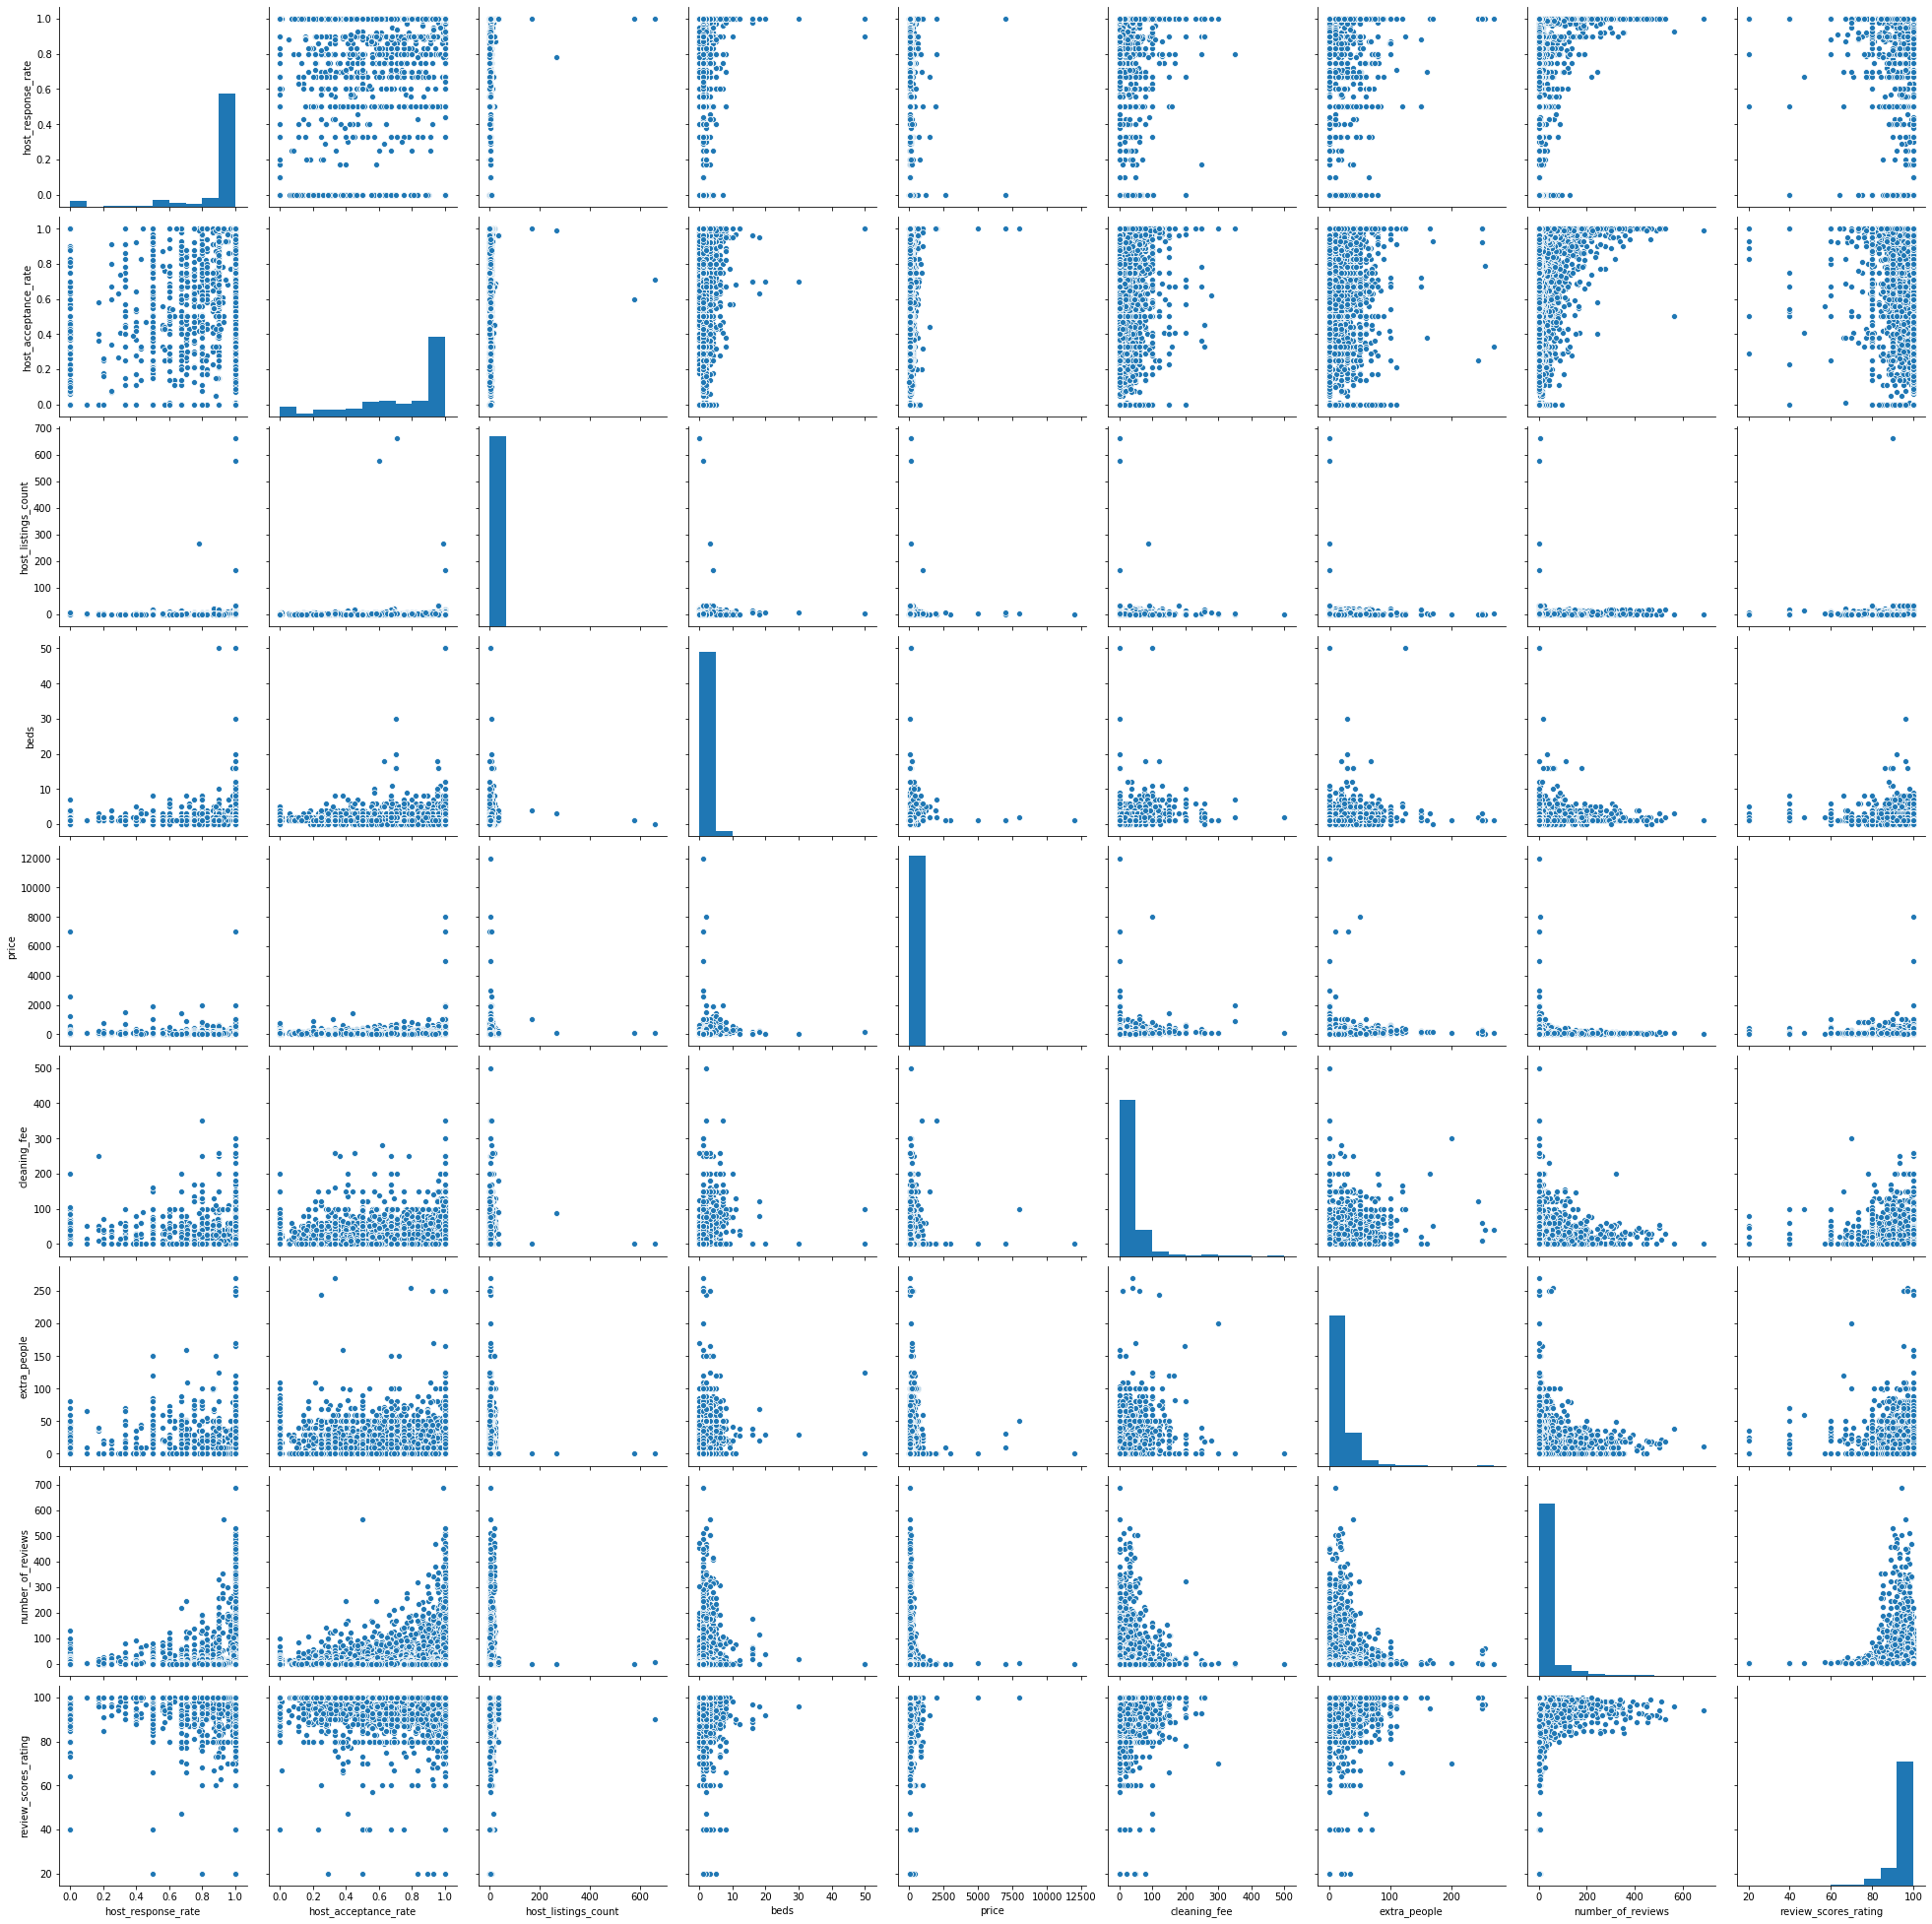

In [15]:
plot_vars=   ['host_response_rate', 'host_acceptance_rate', 'host_listings_count','beds', 'price', 
              'cleaning_fee', 'extra_people','number_of_reviews', 'review_scores_rating']

plt.figure(figsize=(30, 30));
sns.pairplot(df_listings_cleansed[plot_vars], height=3, diag_kind="hist");

The plots show that the majority of these variables are somehow skewed.

We still carry some variables containing nan-values. For the data analytics we do in he first place we will leave them not to distort the statitics by imputed values. We will do another round of data cleaning before we start with the price predictions.

#### Detect pricing outliers
As much of the analysis is focused on the pricing we have a closer look at the distribution of this variable

Upper whisker at : 247.0
This corresponds to q = %.2f 0.9126923076923077


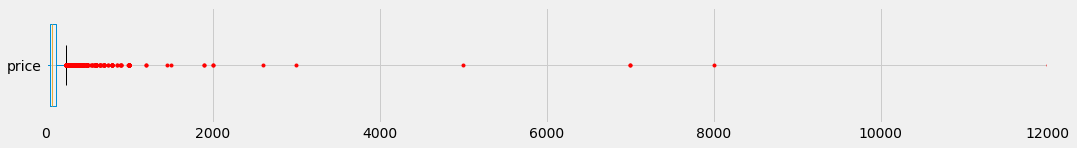

In [16]:
plt.style.use('fivethirtyeight')
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_listings_cleansed['price'].plot(kind='box', xlim =(0, max(df_listings_cleansed.price)), 
                                   vert=False, flierprops=red_square,  widths = 0.7, figsize=(16,2) );

upper_whisker,q = upper_whisker(df_listings_cleansed['price'])
print('Upper whisker at :', upper_whisker)
print('This corresponds to q = %.2f', format(q))

We can see prices up to 12,000 EUR per night. That does not seem plausible. On the other hand we would drop nearly 10% of the data if we follow the Tukey rule and delete all data above the upper whicker. Looking at the boxplot above, a treshhold of 1,000 EUR could be a good compromise. So let's have a closer look at the rooms / appartments that are priced 1,000 EUR +.

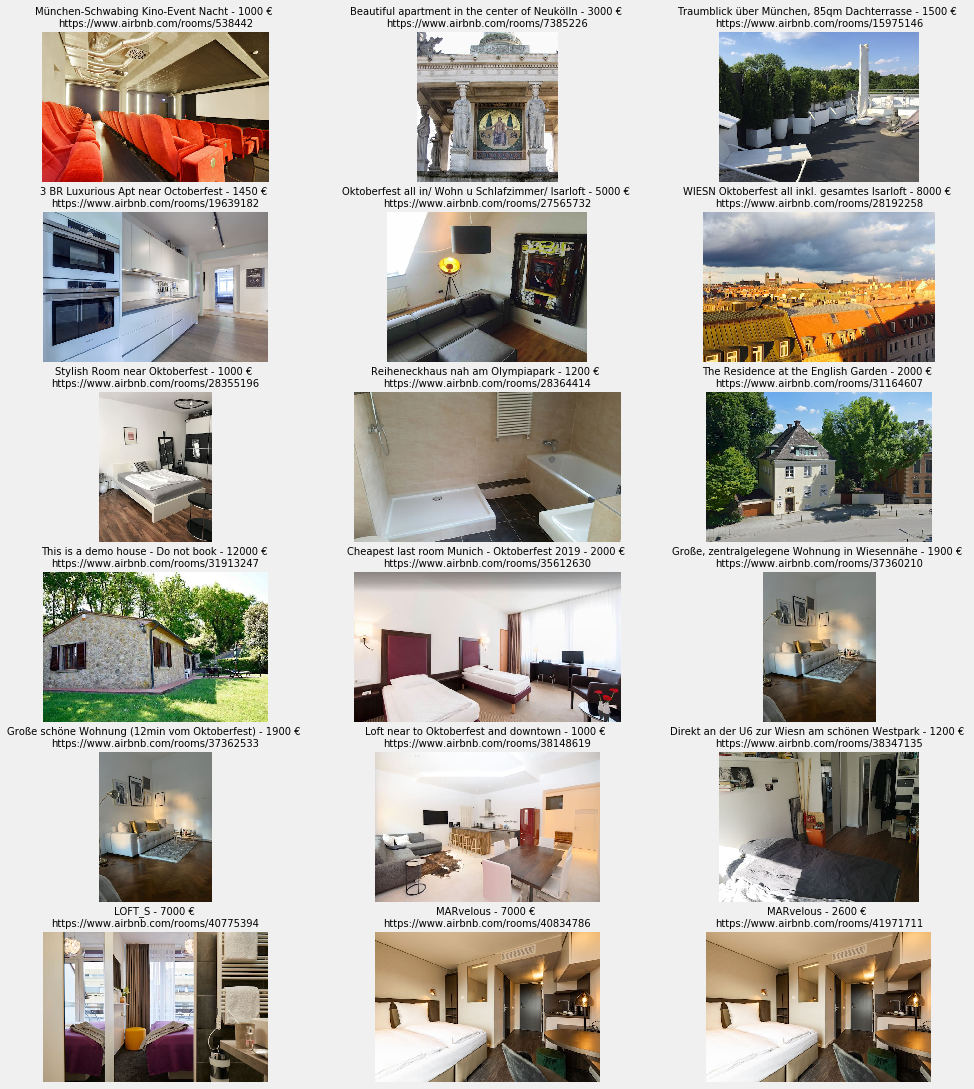

In [17]:
def plot_listings(df, max_cols = 3, figsize = (5, 3)):
    """
        Plots an overview in gridformat of the listings supplied in dataframe df
        Overview cointains name, price, url and a picture of the property
        Args:
            df: Dataframe for which overview is to be generated
            max_cols: maximum number of overview grid columns
            figsize: size of the porperty image            
        Returns:
            None        
    """
    assert df.shape[0] > 0, "Need at least one input"
    assert df.shape[0] <= 100, "Wont plot more than 100 images"
    num_cols = min(df.shape[0], max_cols)
    num_rows = int(df.shape[0] / num_cols)
    fig, plots = plt.subplots(
        num_rows, num_cols, figsize=(figsize[0] * num_cols, figsize[1] * num_rows)
    )
    for r in range(num_rows):
        for c in range(num_cols):
            i = r * num_cols + c
            if not i < df.shape[0]:
                continue
            title = df.name.iloc[i] + ' - ' + str(int(df.price.iloc[i])) + ' € \n' + df.listing_url.iloc[i]
            img = Image.open(requests.get(df.picture_url.iloc[i], stream=True).raw)
          
            plots[r][c].tick_params(top=False, bottom=False, left=False, right=False)
            plots[r][c].imshow(img)
            plots[r][c].axis("off")
            plots[r][c].set_title(title, fontsize = 10)
            
plot_listings(df_listings_cleansed[df_listings_cleansed['price']>=1000])

The descriptions of the listings reveal interesting details: The most expensive is a non-bookable demo, another one is located in Berlin apparently with wrong lat-long data, yet another one is a cinema to be rented for events etc. So we drop all these listings.  
To get a deeper understanding of the price distribution we can plot a histogram.

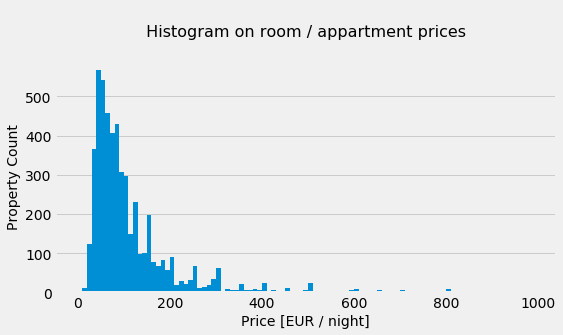

In [18]:
df_listings_cleansed.drop(df_listings_cleansed[df_listings_cleansed['price'] >= 1000.0].index, inplace = True)
plt.figure(figsize=(8,4))
plt.hist(df_listings_cleansed.price, bins = np.arange(0, df_listings_cleansed.price.max(),10))
plt.xlabel('Price [EUR / night]', fontsize = 14)
plt.ylabel('Property Count', fontsize = 14)
plt.grid(axis='x')
plt.title('\n Histogram on room / appartment prices \n', fontsize = 16);

As the data distribution looks highly skewed we apply a log transformation.

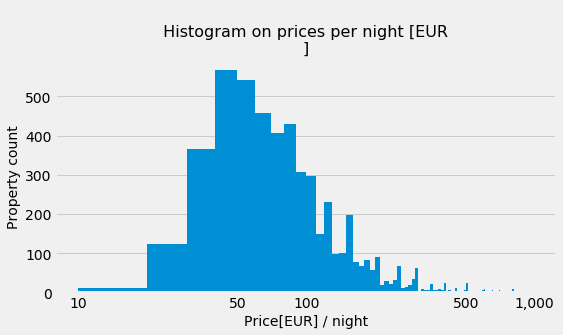

In [19]:
plt.figure(figsize=(8,4))
bins = np.arange(0, df_listings_cleansed.price.max(),10)
ax = plt.hist(df_listings_cleansed.price, bins = bins);
plt.title('\n Histogram on prices per night [EUR \n]', fontsize = 16)
plt.xscale('log')
plt.xticks([10, 50, 100, 500, 1000])
plt.gca().xaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Price[EUR] / night', fontsize = 14)
plt.grid(axis='x')
plt.ylabel('Property count', fontsize = 14);

In [20]:
# retrieve the exact values
df_listings_cleansed.price.value_counts(bins = bins, normalize = True).head(10)

(40.0, 50.0]      0.126399
(50.0, 60.0]      0.094172
(70.0, 80.0]      0.091085
(90.0, 100.0]     0.083751
(60.0, 70.0]      0.083751
(30.0, 40.0]      0.081822
(80.0, 90.0]      0.063682
(140.0, 150.0]    0.043227
(110.0, 120.0]    0.040718
(20.0, 30.0]      0.035122
Name: price, dtype: float64

Most rooms / appartments are offered between 40 and 50 EUR. More than 60% of all rooms / appartments are offered between 30 and 100 EUR.

We can see some high correlations between 

### Calendar data
The second data set contains ...
Let's see  some high-level overviews of the calnedar data.
Before checking this data set for completeness and quality we eliminate all listings associated with rooms / appartments that we eliminated in the listings data set and which therefore are not available for booking

In [21]:
print('Shape of calendar data before cleaning : ', df_calendar.shape)
df_calendar_cleansed = df_calendar[df_calendar.listing_id.isin(df_listings_cleansed.id)]
print('Shape of calendar data after cleaning : ', df_calendar_cleansed.shape)
df_calendar_cleansed.head()

Shape of calendar data before cleaning :  (4087646, 7)
Shape of calendar data after cleaning :  (1891430, 7)


listing_id        date available   price adjusted_price  minimum_nights  \
0       252987  2020-03-20         f  $99.00         $99.00             2.0   
53      252987  2020-03-21         f  $99.00         $99.00             2.0   
54      252987  2020-03-22         f  $99.00         $99.00             2.0   
55      252987  2020-03-23         f  $99.00         $99.00             2.0   
56      252987  2020-03-24         f  $99.00         $99.00             2.0   

    maximum_nights  
0           1125.0  
53          1125.0  
54          1125.0  
55          1125.0  
56          1125.0

Let's check the completeness of the data in the calendar file

In [22]:
df_nan_analysis(df_calendar_cleansed)    

attribute  nan_abs nan_rel
0      listing_id        0    0.0%
1            date        0    0.0%
2       available        0    0.0%
3           price        0    0.0%
4  adjusted_price        0    0.0%
5  minimum_nights        0    0.0%
6  maximum_nights        0    0.0%

As we can see the data is complete. There is no need to drop any rows / columns due to nan values or impute any missing values.

Now let's have a look at the data types.

In [23]:
df_calendar_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1891430 entries, 0 to 4087645
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 115.4+ MB


We can see that we need to do the following adjustments to the dataset:
- transform 'date'-column to a date object in order to perform Time series analysis
- transform 'available'-column to to boolean to safe memory 
- transform the two price columns to float 
- transform minimum/maximum nights column to integer to safe memory

In [24]:
# transform 'date'-column to date format
df_calendar_cleansed['date'] = pd.to_datetime(df_calendar_cleansed['date'], format="%Y-%m-%d")

# transform 'available'-column to boolean
df_calendar_cleansed['available'] = df_calendar_cleansed['available'].apply(transform_boolean)

# transform price columns to float
for col in ['price', 'adjusted_price']:
    df_calendar_cleansed[col] = transform_price(df_calendar_cleansed[col])

# transform minimum / maximum nights to integer
df_calendar_cleansed['minimum_nights'] = df_calendar_cleansed['minimum_nights'].astype(int)
df_calendar_cleansed['maximum_nights'] = df_calendar_cleansed['maximum_nights'].astype(int)

C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

### Reviews data
To study the demand, since we did not have data on the bookings made over the past year, we will use ‘number of reviews’ variable as the indicator for demand. Inside Airbnb suggests an occupancy model that uses a review rate of 50% to convert reviews to estimated bookings, hence studying the number of review will give us a good estimation of the demand. In this context, we do not need to eliminate the non-activerooms / appartments as we want to analyse the historic development.
As before we start with some high-level overviews and an analysis on nan-values.

In [25]:
print('Shape of reviews dataframe : ', df_reviews.shape)
df_reviews.head()

Shape of reviews dataframe :  (175413, 6)


listing_id        id        date  reviewer_id reviewer_name  \
0       36720  12723661  2014-05-09     11840468       Mikhail   
1       36720  13147830  2014-05-20      5466213           Kim   
2       36720  16302574  2014-07-25      2062882       Juan R.   
3       36720  16428874  2014-07-27      1225618         David   
4       36720  19478358  2014-09-13     13977301           Cal   

                                            comments  
0  I would like to thank Gabriella as her apartme...  
1  Gabriela's place was absolutely fantastic.  It...  
2  Quiet place, open to a courtyard, with all the...  
3  The best Airbnb expeierence I've had. The apar...  
4  All first rate ! Beautiful apartment, comforta...

In [26]:
df_nan_analysis(df_reviews)

attribute  nan_abs    nan_rel
0     listing_id        0       0.0%
1             id        0       0.0%
2           date        0       0.0%
3    reviewer_id        0       0.0%
4  reviewer_name        0       0.0%
5       comments       73  0.041616%

We see that the data is pretty complete. As we do not plan any natural language processing / text analysis on the comments we do not care about the missing values in this columns.

Now let's check on the datatypes:

In [27]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175413 entries, 0 to 175412
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     175413 non-null  int64 
 1   id             175413 non-null  int64 
 2   date           175413 non-null  object
 3   reviewer_id    175413 non-null  int64 
 4   reviewer_name  175413 non-null  object
 5   comments       175340 non-null  object
dtypes: int64(3), object(3)
memory usage: 8.0+ MB


The only column we need to take care of is the *date*-column:

In [28]:
df_reviews_cleansed = df_reviews.copy()
df_reviews_cleansed.date = pd.to_datetime(df_reviews_cleansed.date, format="%Y-%m-%d")

No let's see the distribution of the review ratings

C:\Users\frank\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\frank\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


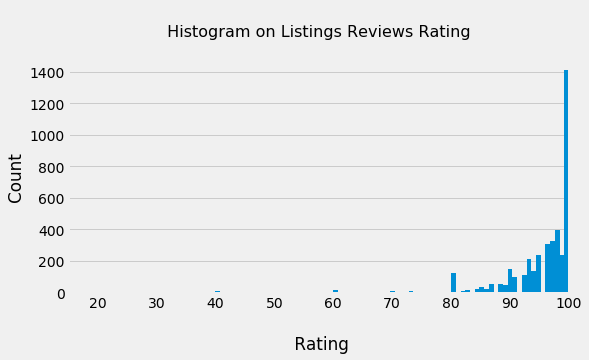

In [29]:
plt.figure(figsize = (8,4))
plt.hist(df_listings_cleansed['review_scores_rating'], bins=100);
plt.xlim(df_listings_cleansed['review_scores_rating'].min()-5, df_listings_cleansed['review_scores_rating'].max())
plt.title('\n Histogram on Listings Reviews Rating \n', fontsize = 16)
plt.ylabel('Count')
plt.xlabel('\n Rating');
plt.grid(axis='x')

The ratings are highly skewed to the right, inidacting that most visitors are extremely satisfied with their experience.

## Data Exploration
### General Statistics

# of location in Munich listed on Airbnb locations : 5182
These are operated by  4116  hosts
Average price per night:  113.70 EUR

The first review ever was posted on  2010-10-07  in  Ludwigsvorstadt - Isarvorstadt


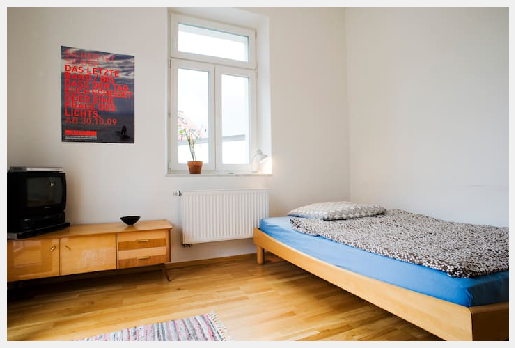

In [30]:
# just to make sure we check on unique values in the id coloumn of the listings table. 
# As it turns out all values are in fact unique
print('# of location in Munich listed on Airbnb locations :', len(df_listings_cleansed['id'].unique()))
print('These are operated by ', len(df_listings_cleansed['host_id'].unique()), ' hosts')
print('Average price per night: ', '{:0.2f} EUR'.format(df_listings_cleansed.price.mean()) )

# retrieve first review ever
df = df_listings.sort_values(by='first_review')
print('\nThe first review ever was posted on ', df.first_review.iloc[0], ' in ', df.neighbourhood.iloc[0])
img = Image.open(requests.get(df.picture_url.iloc[0], stream=True).raw)
plt.figure(figsize = (8,6))
plt.imshow(img);
plt.axis("off")
plt.xlabel('First ever reviewed Airbnb listed appartment in Munich');

### Which room types are the most prominent ones ?
Let's have a look at what kind of rooms are offered

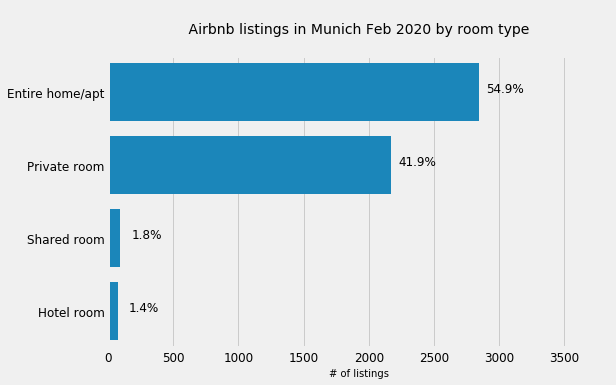

In [31]:
plt.figure(figsize = (8,5))
basecolor = sns.color_palette()[0]
sns.countplot(data = df_listings_cleansed, y = 'room_type', color = basecolor, 
              order = df_listings_cleansed['room_type'].value_counts().index)
plt.ylabel('')
plt.xlabel('# of listings', fontsize = 10)
plt.title('\n Airbnb listings in Munich Feb 2020 by room type \n', fontsize = 14)

plt.xticks(fontsize =12)
plt.yticks(fontsize =12)

# add annotations
n_points = df_listings_cleansed.shape[0]
cat_counts = df_listings_cleansed['room_type'].value_counts()
locs, labels = plt.yticks() # get the current tick locations and labels
plt.xlim((0,cat_counts.max()+1000))

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(count+200, loc, pct_string, ha = 'center', color = 'black', fontsize = 12)

### Do different city districts favor different room types ? 
Here we look how the shares of the listed room types vary by city district.

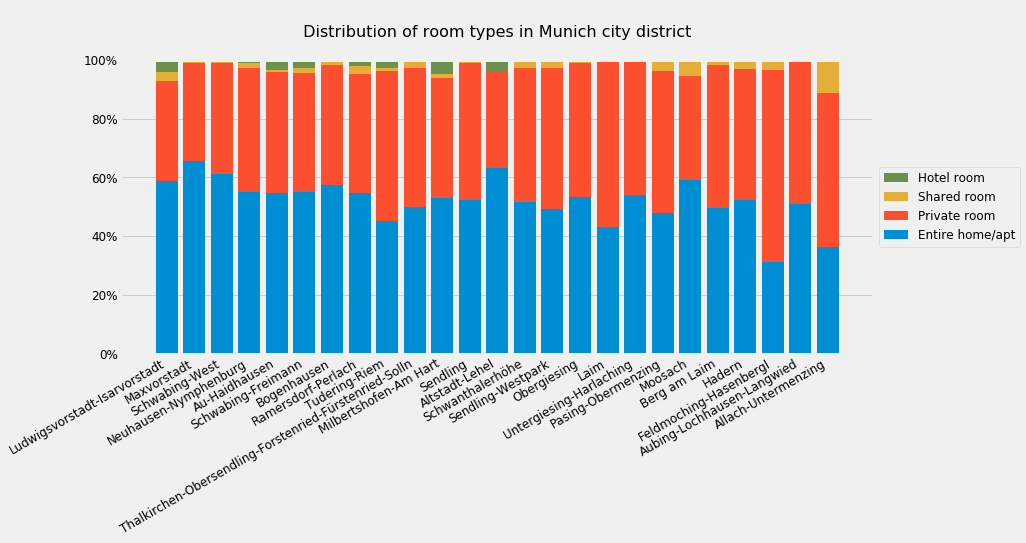

In [32]:
# create the categories 
room_type = pd.Series(df_listings_cleansed['room_type'].value_counts().index)
neighbourhood = pd.Series(df_listings_cleansed['neighbourhood_cleansed'].value_counts().index)

plot_elements = [] # for storing references to plot elements
baselines = np.zeros(len(neighbourhood)) # stores the baseline for the next category plot
nb_counts = df_listings_cleansed['neighbourhood_cleansed'].value_counts()

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate()   # rotate text on x-axis

# for each second-variable category:
for i in range(len(room_type)):
    # isolate the counts of the first category,
    rt = room_type[i]
    inner_counts = df_listings_cleansed[df_listings_cleansed['room_type'] == rt]['neighbourhood_cleansed'].value_counts()
    inner_props = inner_counts / nb_counts
    # correct division by 0 - 
    # otherwise the plot will stop for a neighboorhood as soon as nan-value exists for a specific room-type
    inner_props[inner_props.isnull()] = 0
    
    # then plot those counts on top of the accumulated baseline
    bars = plt.bar(x = np.arange(len(neighbourhood)),
                   height = inner_props[neighbourhood],
                   bottom = baselines)
    plot_elements.append(bars)
    baselines += inner_props[neighbourhood]

plt.title('\n Distribution of room types in Munich city district \n', fontsize = 16)
plt.xticks(np.arange(len(neighbourhood)), neighbourhood)
yt = np.arange(0, 1.1, .2)
plt.yticks(yt, ['{:1.0f}%'.format(100*x) for x in yt])
plt.legend(reversed(plot_elements), reversed(room_type), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6, fontsize = 12);

ax.tick_params(axis='both', labelsize=12)

### How do the number of listed locations and the and rooms / appartment prices vary by city district ?
Here we are interested about the average prices and the number of listed locations in the different city districts.

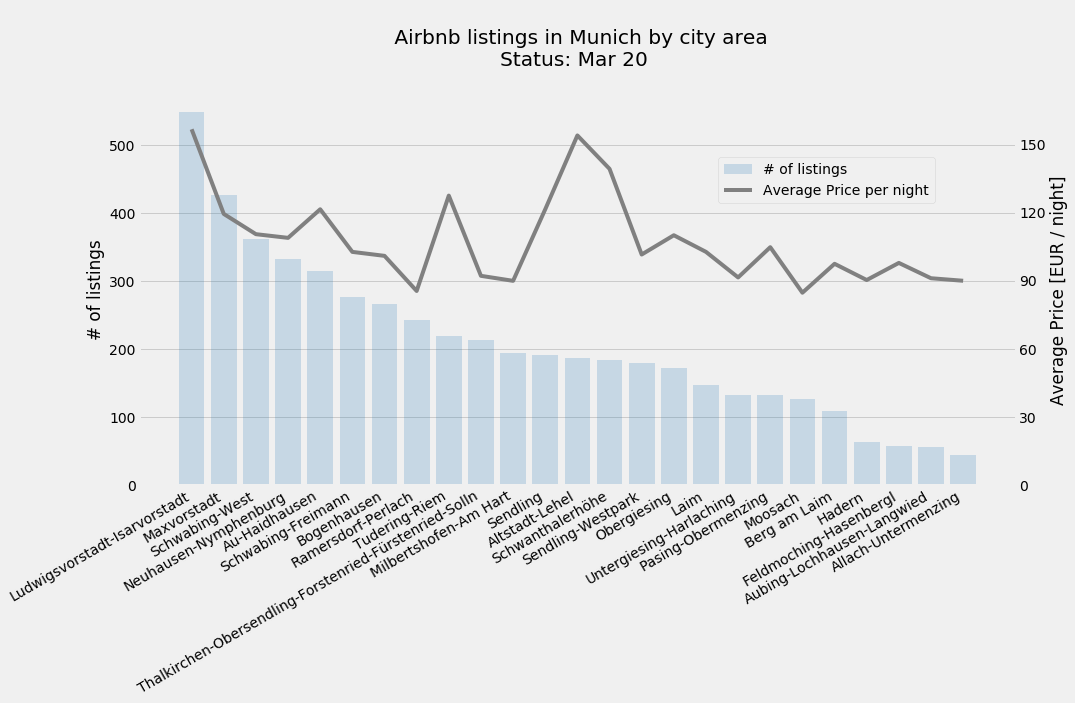

In [33]:
# Prapare a new dataframe for plots

df_listings_neighbourhood_avPrice = df_listings_cleansed.groupby('neighbourhood_cleansed').mean().reset_index()[['neighbourhood_cleansed','price']]

df_listings_neighbourhood_count = df_listings_cleansed.groupby('neighbourhood_cleansed').count().reset_index()[['neighbourhood_cleansed','id']].rename(columns={'id':'count'})

df_listings_neighbourhood = df_listings_neighbourhood_avPrice.merge(df_listings_neighbourhood_count, 
                                                                    on='neighbourhood_cleansed', how='inner')
df_listings_neighbourhood.sort_values('count', ascending = False, inplace = True)

# do the plot
plt.style.use('fivethirtyeight') # using the fivethirtyeight matplotlib theme

fig, ax1 = plt.subplots(figsize=(14,8))
fig.autofmt_xdate()   # rotate text on x-axis

ax2 = ax1.twinx()  # set up the 2nd axis for the pricing plot

ax2.plot(df_listings_neighbourhood['neighbourhood_cleansed'], df_listings_neighbourhood['price'], color = "grey") # plot average price as line
ax1.bar(df_listings_neighbourhood['neighbourhood_cleansed'],df_listings_neighbourhood['count'], 
        width=0.8, alpha=0.2, color=base_color) # plot # of listings as bar chart

fig.legend(['# of listings', 'Average Price per night'], fontsize = 14, loc='upper center', 
           bbox_to_anchor=(0.57, 0.46, 0.5, 0.5))

ax2.grid(b=False) # turn off grid #2

ax1.set_title('\n Airbnb listings in Munich by city area\nStatus: Mar 20 \n')
ax2.set_ylabel('Average Price [EUR / night]')
ax1.set_ylabel('# of listings');
ax1.tick_params(axis='x', grid_linewidth = 0)
ax2.set_ylim(0,172)
ax2.set_yticks(np.arange(0,160,30));

As the chart above illsutrates the price mean values only, a boxplot will give deeper insights into the price ranges in the different districts.

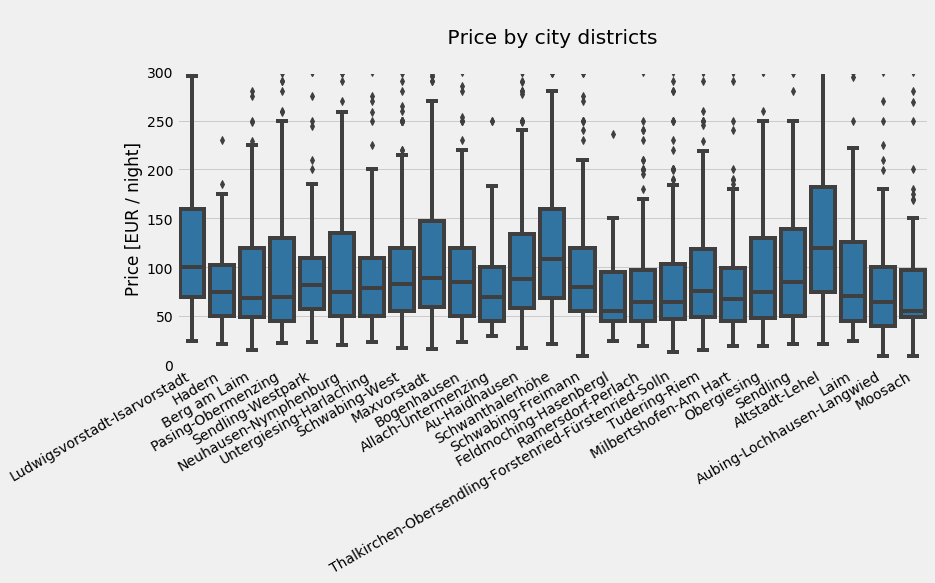

In [34]:
fig, ax1 = plt.subplots(figsize = (12,6))
fig.autofmt_xdate()   # rotate text on x-axis
sns.boxplot(data = df_listings_cleansed, x ='neighbourhood_cleansed', y='price' , color = base_color)
plt.ylabel("Price [EUR / night]")
plt.ylim(0,300);
plt.xlabel("")
plt.title('\n Price by city districts \n');

Let's see the data illustrated on the city map

In [35]:
import plotly.express as px

df = df_listings_cleansed[df_listings_cleansed.price > 1000]

df = df_listings_cleansed.copy(deep = False)
df.sort_values(by='price', inplace=True, ascending=True)

fig = px.scatter_mapbox(df, color='price', lat='latitude', lon='longitude',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10, 
                        mapbox_style='stamen-terrain' ,width=1000, height=800, opacity = 0.5);
fig.show()

### How did demand develop historically and how does it fluctuate seasonally ?

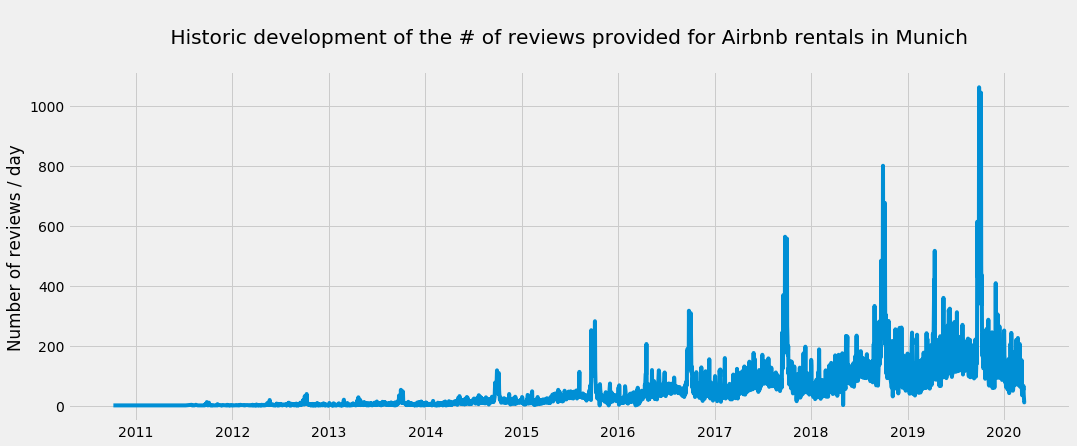

In [36]:
df = df_reviews_cleansed.groupby('date').count().reset_index()

plt.figure(figsize = (16,6))
plt.title('\n Historic development of the # of reviews provided for Airbnb rentals in Munich \n')
plt.ylabel('Number of reviews / day')
plt.plot(df.date,df.id);

From this chart one can already suspect that there has been lately a sharp drop in demand. A year-on-year comparison should illustrate this more clearly.

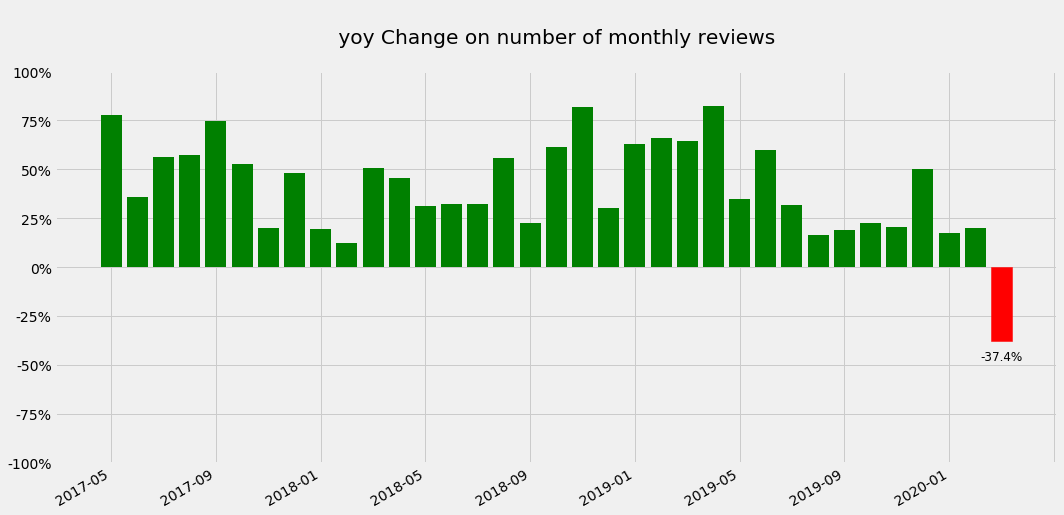

In [37]:
# generate new feature 'Y/M' for grouping
df_ym = df_reviews_cleansed.copy(deep = True)
df_ym['Y/M'] = df_ym['date'].dt.strftime('%Y-%m')
df_ym = df_ym.groupby('Y/M').count().reset_index().rename(columns={'id':'count'})

# adjust March 2020 to full month
# as the data ends on March 19 we nearally extrapolate to month end
df_ym.loc[df_ym.shape[0]-1,'count'] = round(df_ym.loc[df_ym.shape[0]-1,'count']/19*31,0)

# calculate yoy changes
df_ym['yoy'] = (df_ym['count'] - df_ym['count'].shift(12))/ df_ym['count'].shift(12)

# extract the last 3 years for better visualization
df_ym = df_ym.tail(35).reset_index()

fig, ax = plt.subplots(figsize = (16,8))
tick_spacing = 4
fig.autofmt_xdate()   # rotate text on x-axis
ax.bar(df_ym['Y/M'] ,df_ym['yoy'], color='g')
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))
plt.gca().yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
plt.ylim((-1.0,1.0));

plt.title('\n yoy Change on number of monthly reviews \n')

# Add annotation and highlight color to last bar
ax.get_children()[df_ym['yoy'].shape[0]-1].set_color('r')
locs, labels = plt.xticks() # get the current tick locations and labels
pct_string = '{:0.1f}%'.format(100*df_ym.loc[df_ym.shape[0]-1 , 'yoy'])
plt.text(locs[locs.size-1] - 6, df_ym.loc[df_ym.shape[0]-1 , 'yoy'] - .1, pct_string, ha = 'center', color = 'black', fontsize = 12);

We clearly can see the yoy drop in demand in March 2020. In fact it is the first ever that a negative yoy value occurs. And just to recall. This is a conservative estimatition as we extrapolated the March 2020 figure linearly to the full month. In fact, official restrictions on leaving homes have been already enforced in Bavaria on March 24.


### How do the rental prices fluctuate over the year / within a week ? 

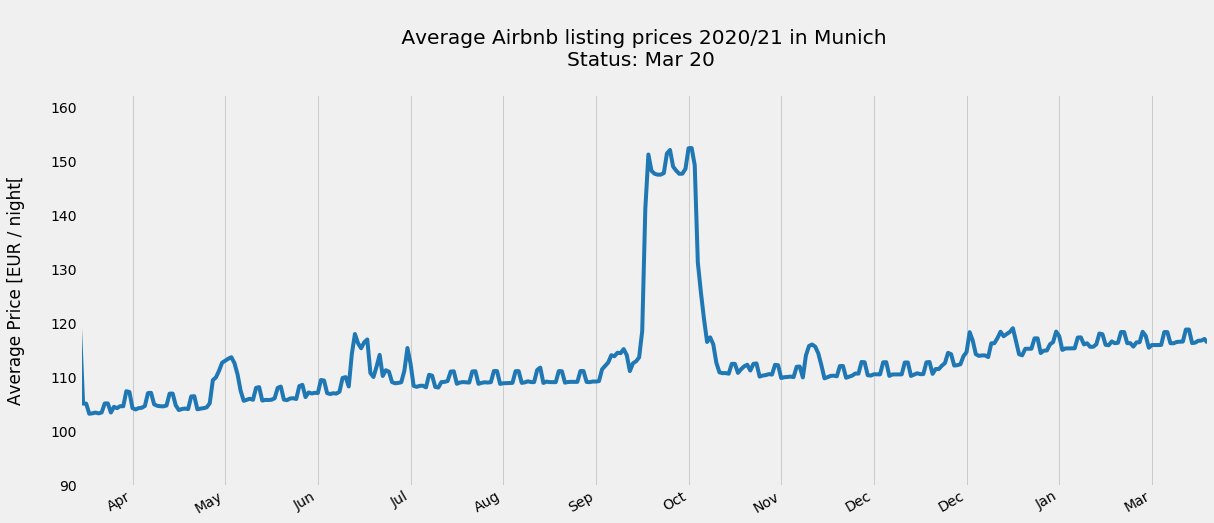

In [38]:
df_mean_price = df_calendar_cleansed.groupby('date').mean().reset_index().sort_values('date')

plt.style.use('fivethirtyeight') # using the fivethirtyeight matplotlib theme9

fig, ax = plt.subplots(figsize = (18,8))
fig.autofmt_xdate()   # rotate text on x-axis

plt.plot(df_mean_price['date'], df_mean_price['price'], color=base_color) # plot average price as line chart

plt.title('\n Average Airbnb listing prices 2020/21 in Munich \nStatus: Mar 20 \n')
plt.ylabel('Average Price [EUR / night[\n ')
loc = plticker.MultipleLocator(base=30) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.grid(axis="y")
plt.ylim((90,df_mean_price['price'].max()+10));
plt.xlim(df_mean_price['date'].min(), df_mean_price['date'].max());

Now let's see how prices fluctuate within a week

C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



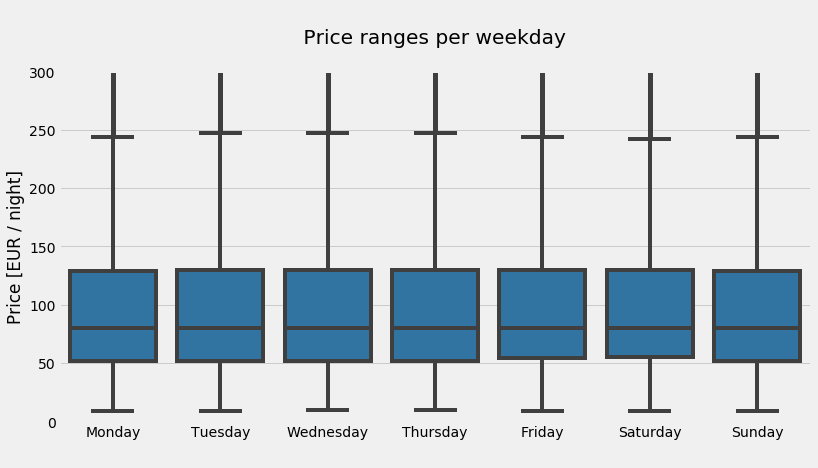

In [39]:
# generate new feature 'weekday'
df_calendar_cleansed['weekday'] = df_calendar_cleansed['date'].dt.day_name()

# Show a Boxplot to see the price distribution per weekday
plt.figure(figsize=(12, 6))

sns.boxplot(x='weekday', y='price', data=df_calendar_cleansed, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color = base_color);

plt.title('\n Price ranges per weekday \n')
plt.ylabel("Price [EUR / night]")
plt.xlabel(" ")
plt.ylim(0, 300);

The median appears parctically constant throughout the week. But the upper whisker is lower around the weekend meaning that more listings are offered at a higher rate and this explains the increase of teh average price that we could see in the previous plot.

### Which are the most important features to predict room / apartment prices ?
Here with start with Machine learning. To predict the prices we use a random forest regressor, which is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Before applying the regressor, we need to encode the categorial variables that we want to utilize and impute or drop remaining missing values.

## Data preparation

In [40]:
# Copy the data to a new DataFrame for encoding 
df_listings_encoded = df_listings_cleansed.copy(deep=True)
df_listings_encoded.select_dtypes('object').info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5182 entries, 0 to 5199
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   listing_url             5182 non-null   object
 1   name                    5181 non-null   object
 2   summary                 4815 non-null   object
 3   space                   3621 non-null   object
 4   description             5028 non-null   object
 5   neighborhood_overview   3097 non-null   object
 6   notes                   1755 non-null   object
 7   transit                 3505 non-null   object
 8   access                  2416 non-null   object
 9   interaction             2893 non-null   object
 10  house_rules             2660 non-null   object
 11  picture_url             5182 non-null   object
 12  host_url                5182 non-null   object
 13  host_name               5181 non-null   object
 14  host_location           5161 non-null   object
 15  host

For quite some of these features we do not expect to contribute additional value to the analysis due too several reasons:
- It's hard too derive any useful information directly out of the features, e.g. the different urls
- Features with a high share nan-values (see analysis above) like notes, access etc. would require substantial imputation and thus diluting the feature information 
- Some features overlap with others (e.g. zipcode and neighbourhood)
- Features with in fact constant data only in different format, e.g. State contains values as Bayern, Bavaria, BY, Baviera

In [41]:
features_to_drop = ['notes', 'access', 'house_rules', 'host_about', 'listing_url', 'picture_url','host_url', 
                    'host_thumbnail_url','host_picture_url','name', 'summary', 'space', 'neighborhood_overview', 
                    'transit', 'interaction', 'description','host_name', 'host_location', 'host_neighbourhood', 
                    'street', 'last_scraped', 'zipcode', 'calendar_last_scraped', 'first_review', 'last_review', 
                    'host_since', 'calendar_updated', 'state', 'city', 'market', 'host_total_listings_count', 
                    'smart_location', 'neighbourhood']
df_listings_encoded.drop(features_to_drop, axis=1, inplace=True)

In [42]:
# Show the remaining features and the data type
df_listings_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5182 entries, 0 to 5199
Data columns (total 60 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         5182 non-null   int64  
 1   id                                            5182 non-null   int64  
 2   host_id                                       5182 non-null   int64  
 3   host_response_time                            3951 non-null   object 
 4   host_response_rate                            3951 non-null   float64
 5   host_acceptance_rate                          4771 non-null   float64
 6   host_is_superhost                             5182 non-null   bool   
 7   host_listings_count                           5181 non-null   float64
 8   host_verifications                            5182 non-null   object 
 9   host_has_profile_pic                          5182 non-null   b

In [43]:
## Fill numerical missing data with mean value
numerical_columns = df_listings_encoded.select_dtypes(np.number).columns

for col in numerical_columns:
    df_listings_encoded[col] = df_listings_encoded[col].fillna(df_listings_encoded[col].mean())

# Remove all remaining missing values  
df_listings_encoded.dropna(inplace=True)

In [44]:
# Encode features for use in machine learning model

# Encode feature 'amenities' and concat the data
df_listings_encoded.amenities = df_listings_encoded.amenities.str.replace('[{""}]', "")
df_amenities = df_listings_encoded.amenities.str.get_dummies(sep=",")
df_listings_encoded = pd.concat([df_listings_encoded, df_amenities], axis=1) 

# Encode feature 'host_verification' and concat the data
df_listings_encoded.host_verifications = df_listings_encoded.host_verifications.str.replace("['']", "")
df_verification = df_listings_encoded.host_verifications.str.get_dummies(sep=",")
df_listings_encoded = pd.concat([df_listings_encoded, df_verification], axis=1)
    
# Encode feature 'host_response_time'
dict_response_time = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4}
df_listings_encoded['host_response_time'] = df_listings_encoded['host_response_time'].map(dict_response_time)

# Encode the remaining categorical feature 
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']:
    df_listings_encoded = pd.concat([df_listings_encoded, 
                                     pd.get_dummies(df_listings_encoded[categorical_feature], prefix = categorical_feature)], axis=1)
        
# Drop features columns that have been encoded
df_listings_encoded.drop(['amenities', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 
                          'host_verifications', 'cancellation_policy','security_deposit',
                          'id', 'host_id', 'latitude', 'longitude'],
                         axis=1, inplace=True)

In [45]:
# Check the number of variables to be used for regression
df_listings_encoded.shape

(3951, 278)

In [46]:
# Shuffle the data to ensure a good distribution
df_listings_encoded = shuffle(df_listings_encoded)

X = df_listings_encoded.drop(['price', 'weekly_price', 'monthly_price', 'index'], axis = 1)
y = df_listings_encoded['price']

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Modeling

In [47]:
# Initalize the model
model = RandomForestRegressor(max_depth=15, n_estimators=200, criterion='mse', random_state=42)
# Fit the model on training data
model.fit(X, y)
        
# Predict results
prediction = model.predict(X_test)

## Evaluation
Now let's check the results, the feature importance and visualize the results

In [48]:
# Evaluate the result - compare r squared of the training set with the test set

print("Training Set - R²-score:", round(model.score(X_train, y_train) ,2))
print("Test Set -     R²-score:", round(model.score(X_test, y_test), 2))

Training Set - R²-score: 0.91
Test Set -     R²-score: 0.91


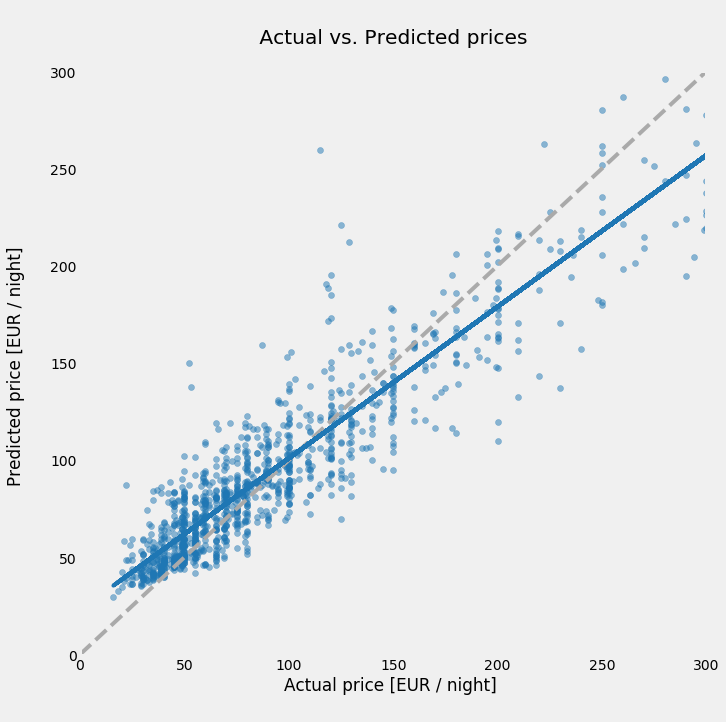

In [49]:
# Scatter plot of the actual vs predicted data
plot_range = 300
plt.figure(figsize=(10, 10))
plt.grid()
plt.xlim((0, plot_range))
plt.ylim((0, plot_range))
# reference line
plt.plot([0,plot_range],[0,plot_range], color='#AAAAAA', linestyle='dashed')
# predictions as scatter plot
plt.scatter(y_test, prediction, alpha=0.5, color = base_color)

coef = np.polyfit(y_test,prediction,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test, poly1d_fn(y_test), color = base_color)
plt.title('\n Actual vs. Predicted prices \n');
plt.xlabel("Actual price [EUR / night] \n")
plt.ylabel("Predicted price [EUR / night] \n")
plt.show()

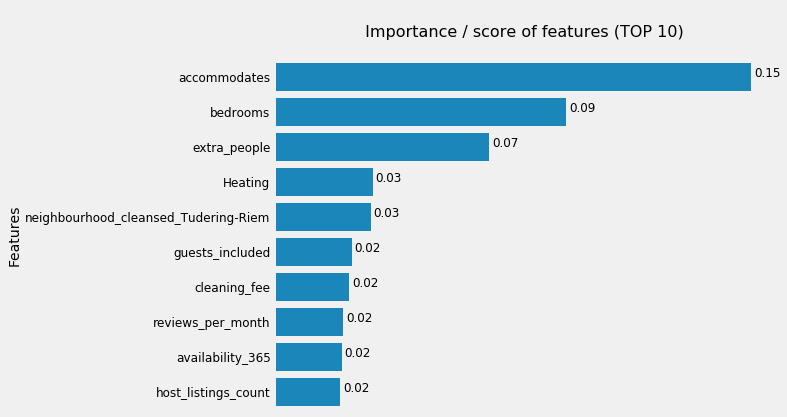

In [50]:
# Sort the importance of the features
importances = model.feature_importances_
    
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns=["feature", "score"])
feature_importances = feature_importances.sort_values(by=['score'], ascending = False)

features = feature_importances['feature'][:10]
y_feature = np.arange(len(features))
score = feature_importances['score'][:10]

# Plot the importance of a feature to the price

plt.figure(figsize=(8,6));
sns.barplot(y = features, x = score, color = basecolor);
plt.xticks([])
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.ylabel('Features', fontsize = 14);
plt.title('\n Importance / score of features (TOP 10) \n', fontsize = 16);

# annotate bars
locs, labels = plt.yticks() # get the current tick locations and labels
# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # print the annotation just right the top of the bar
    plt.text(score[loc]+.005, loc, '{:0.2f}'.format(score[loc]), ha = 'center', color = 'black', fontsize = 12)

This gives a little bit a biased view as the importance of the variables that have been encoded are spread over all the specific values of this variable. So let's have a look of the total impact of the amenities and the most important among them:

In [51]:
print('Total importance of total amenities : %4.2f' % feature_importances[feature_importances['feature'].isin(df_amenities.columns)].score.sum())
print('Top 10 amenities for price prediction:')
feature_importances[feature_importances['feature'].isin(df_amenities.columns)].head(10)


Total importance of total amenities : 0.16
Top 10 amenities for price prediction:


feature     score
3                     Heating  0.030538
34                  Hot water  0.005983
35             Smoke detector  0.005891
38                      Dryer  0.005266
44        Free street parking  0.004160
47                 Beachfront  0.003760
53               Game console  0.002982
56  Paid parking off premises  0.002636
57   Paid parking on premises  0.002564
60                 EV charger  0.002388

In [52]:
print('Total importance of neighbourhood : %4.2f' % feature_importances[feature_importances['feature'].isin('neighbourhood_cleansed'+'_'+df_listings_cleansed.neighbourhood_cleansed.unique())].score.sum())
print('Top 10 neighbourhoods for price prediction:')
feature_importances[feature_importances['feature'].isin('neighbourhood_cleansed'+'_'+df_listings_cleansed.neighbourhood_cleansed.unique())].head(10)


Total importance of neighbourhood : 0.07
Top 10 neighbourhoods for price prediction:


feature     score
4                 neighbourhood_cleansed_Tudering-Riem  0.029937
36             neighbourhood_cleansed_Schwanthalerhöhe  0.005699
40                     neighbourhood_cleansed_Sendling  0.005032
41               neighbourhood_cleansed_Altstadt-Lehel  0.004973
46   neighbourhood_cleansed_Ludwigsvorstadt-Isarvor...  0.003828
49                  neighbourhood_cleansed_Obergiesing  0.003563
58                neighbourhood_cleansed_Au-Haidhausen  0.002440
66                  neighbourhood_cleansed_Maxvorstadt  0.002221
104              neighbourhood_cleansed_Schwabing-West  0.001421
121       neighbourhood_cleansed_Neuhausen-Nymphenburg  0.001127